In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import PotentialOne, PotentialTwo, PotentialThree, PotentialOnePrime
from zv_cv import Eval_ZVCV_Gaus
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import copy

In [2]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**5 # Number of samples on which we optimize
step = 0.1 # Step size
#put 0.5 for MALA
#step = 0.2
n_traj = 20 # Number of independent MCMC trajectories for test
f_type = "sum"
bn = 100
W_test = construct_ESVM_kernel(N_train,bn)

Choose density parameters

In [3]:
d = 2
#B = np.pi/2
M = 1.0
mu = 3.0
sigma = 3.0
Cur_pot = PotentialThree(M,mu,sigma,d)
#mu = 0.5
#sigma = 0.5
#M = 1.0
#Cur_pot = PotentialTwo(M,mu,sigma,d)

### Visualize level sets of the potential

In [4]:
mu_1 = 3.0
mu_2 = 3.0
M = 1.0
sigma = 3.0
###
def U(x, y):
    return -1./(2*M**2)*(np.sqrt(x**2 + y**2) - mu_1)**2 + np.log(np.exp(-1/(2*sigma**2)*(x-mu_2)**2) + np.exp(-1/(2*sigma**2)*(x+mu_2)**2))

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)

X, Y = np.meshgrid(x, y)
Z = np.exp(U(X, Y))

(-5.0, 5.0, -5.0, 5.0)

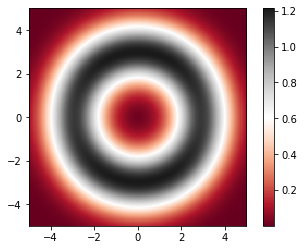

In [5]:
plt.imshow(Z, extent=[-5, 5, -5, 5], origin='lower',
           cmap='RdGy')
plt.colorbar()
plt.axis(aspect='image')

### Generate data

In [8]:
sampler = {"sampler":"ULA","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12


Process ForkPoolWorker-13:
Process ForkPoolWorker-18:
Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-15:
Process ForkPoolWorker-20:
Process ForkPoolWorker-16:
Process ForkPoolWorker-14:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _

KeyboardInterrupt
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
KeyboardInterrupt
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/svsamsonov/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


### Visualize training trajectories

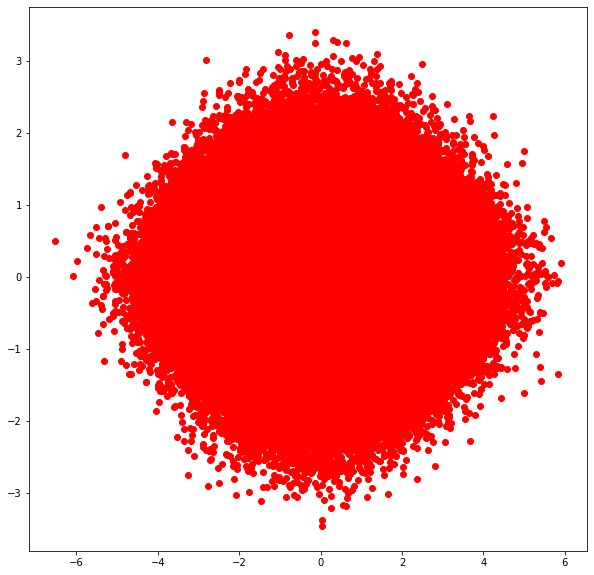

In [9]:
visualize_scatter_2d(traj[0,:,:])

### Run variance reduction

In [10]:
print(traj.shape)
print(traj_grad.shape)
traj_grad = (-1)*traj_grad

(20, 100000, 2)
(20, 100000, 2)


In [42]:
from baselines import set_function, Spectral_var
from zv_cv import ZVpolyOne
def GausCV(traj,sample):
    """
    returns matrix of gaussian CV's 
    """
    m=7
    pen=0.
    x = np.linspace(-5,5,m)
    y = np.linspace(-5,5,m)
    sigma_squared = 3.0
    xx, yy = np.meshgrid(x,y)
    d = m**2
    mu = np.concatenate((xx.reshape((-1,1)),yy.reshape((-1,1))),axis=1)
    traj_adj = (np.repeat(traj[:,np.newaxis,:], d, axis=1)-mu[np.newaxis,:])/sigma_squared
    psi_matr = np.zeros((d,traj.shape[0]))
    for i in range(d):
        psi_matr[i,:] = np.exp(-np.sum((traj-mu[i].reshape((1,2)))**2, axis=1)/(2*sigma_squared))
    cov = np.dot(psi_matr - psi_matr.mean(axis=0),sample - sample.mean()) / traj.shape[0]
    jac_matr = -traj_adj*((psi_matr.T).reshape((psi_matr.shape[1],psi_matr.shape[0],1)))
    H = np.mean(np.matmul(jac_matr,jac_matr.transpose(0,2,1)),axis=0)
    param_CV = np.linalg.inv(H + pen*np.eye(H.shape[0])) @ cov                                                                                 
    jac_star = np.sum(jac_matr*param_CV[np.newaxis,:],axis=1)
    print(jac_star.shape)
    delta_star = (psi_matr.T*(np.sum(traj_adj**2, axis=2)-traj.shape[1]/sigma_squared)).dot(param_CV)
    return jac_star,delta_star

def GausCV_adj(traj,traj_grad,samples,f_target,params,W_spec):
    """
    returns matrix of gaussian CV's 
    """
    #m=7 - good
    m=7
    lambda_reg=0.
    x = np.linspace(-5,5,m)
    y = np.linspace(-5,5,m)
    sigma = np.sqrt(3.0)
    xx, yy = np.meshgrid(x,y)
    d = m**2
    #print(xx)
    mu = np.concatenate((xx.reshape((-1,1)),yy.reshape((-1,1))),axis=1)
    #Nabla_psi = np.zeros((d,samples.shape[0]),dtype=float)
    Psi = np.zeros((d,samples.shape[0]),dtype=float)
    L_psi = np.zeros((d,samples.shape[0]),dtype=float)
    for i in range(d):
        #Nabla_psi[i] = (i+1)*(traj[:,0]**i)
        Psi[i] = np.exp(-(np.sum((traj-mu[i])**2,axis=1)/(2*sigma**2)))
        L_psi[i] = (np.sum(traj_grad*(traj-mu[i])/sigma**2,axis=1) \
                    +(np.sum((traj-mu[i])**2,axis=1)/sigma**4 - traj.shape[1]/sigma**2))*Psi[i]
    #compute main matrix
    Pois = np.concatenate([Psi,-L_psi],axis=0)
    Cov_matr = np.cov(Pois,rowvar = True)
    H_cv = Cov_matr[:d,d:]
    b_cv = ((Psi - Psi.mean(axis=1).reshape(deg,1)) @ (samples - samples.mean(axis=0)))/(samples.shape[0]-1)
    theta = np.linalg.inv(H_cv + lambda_reg*np.eye(deg)) @ b_cv
    CV_est = samples + L_psi.T @ theta
    mean_CV = np.mean(CV_est, axis = 0)
    var_CV = Spectral_var(CV_est[:,0],W_spec)
    return mean_CV, var_CV                    

def CVpolyGaussian(traj, traj_grad, f_target, params, W_spec):
    n,d = traj.shape
    if f_target == "sum":
        samples = traj.sum(axis = 1).reshape(-1,1)
    elif f_target == "sum_comps":
        samples = traj[:,params["ind"]].reshape(-1,1)
    elif f_target == "sum_squared":
        samples = np.square(traj).sum(axis = 1).reshape(-1,1)
    elif f_target == "sum_comps_squared":
        samples = np.square(traj[:,params["ind"]]).reshape(-1,1)
    elif f_target == "sum_4th":
        samples = ((traj)**4).sum(axis = 1).reshape(-1,1)
    elif f_target == "exp_sum":
        samples = np.exp(traj.sum(axis = 1)).reshape(-1,1)
    else:
        traj = np.expand_dims(traj, axis = 0)
        samples = set_function(f_target,traj,[0],params)
        traj = traj[0]
        samples = samples[0]
    jac,delta = GausCV(traj,samples)
    CV = samples - np.sum(traj_grad*jac, axis = 1).reshape((-1,1)) + delta
    #CV = -np.sum(traj_grad*jac, axis = 1).reshape((-1,1)) + delta.reshape((-1,1))
    mean_CV = np.mean(CV, axis = 0)
    #print(mean_CV)
    var_CV = Spectral_var(CV[:,0],W_spec)
    return mean_CV, var_CV

def Eval_ZVCV_Gaus(traj,traj_grad, f_target, params, W_spec):
    if f_target == "sum":
        samples = traj.sum(axis = 1).reshape(-1,1)
    elif f_target == "sum_comps":
        samples = traj[:,params["ind"]].reshape(-1,1)
    elif f_target == "sum_comps_squared":
        samples = np.square(traj[:,params["ind"]]).reshape(-1,1)
    elif f_target == "sum_squared":
        samples = np.square(traj).sum(axis = 1).reshape(-1,1)
    elif f_target == "sum_4th":
        samples = ((traj)**4).sum(axis = 1).reshape(-1,1)
    elif f_target == "exp_sum":
        samples = np.exp(traj.sum(axis = 1)).reshape(-1,1)
    else:
        traj = np.expand_dims(traj, axis = 0)
        samples = set_function(f_target,traj,[0],params)
        traj = traj[0]
        samples = samples[0]
    mean_vanilla = np.mean(samples)
    vars_vanilla = Spectral_var(samples[:,0],W_spec)
    mean_ZV, var_ZV = ZVpolyOne(traj,traj_grad,f_target,params,W_spec)
    mean_CV_vanilla, var_CV_vanilla = CVpolyGaussian(traj,traj_grad,f_target,params,W_spec)
    mean_CV_adj, var_CV_adj = GausCV_adj(traj,traj_grad,samples,f_target,params,W_spec)                     
    return (mean_vanilla,mean_ZV,mean_CV_vanilla,mean_CV_adj), (vars_vanilla,var_ZV,var_CV_vanilla,var_CV_adj)

In [43]:
test_seed = 1453
f_type = "sum"
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV_Gaus, [(traj[i,:,:],traj_grad[i,:,:],f_type,None,W_test) for i in range (n_traj)])
trav.close()

(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)
(100000, 2)


NameError: name 'deg' is not defined

In [ ]:
res_arr = np.asarray(res)
print(res_arr.shape)

### Saving results

In [ ]:
#np.save("rezende/rwm_quadratic_15_04.npy",res_arr)
print("Average vr rates:")
print("ZV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,1]))
print("CV-1:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
#print("ZV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,2]))
#print("CV-2:",np.mean(res_arr[:,1,0]/res_arr[:,1,4]))

### Comparison plots

In [ ]:
title = ""
labels = ['Vanilla\n RWM', 'RWM \nwith ZV-1', 'RWM \nwith CV-1']

In [ ]:
data = [res_arr[:,0,0],res_arr[:,0,1],res_arr[:,0,2]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['ULA \nwith ZV-1', 'ULA \nwith CV-1']

In [ ]:
data = [res_arr[:,0,1],res_arr[:,0,3]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['Vanilla\n MALA', 'MALA \nwith ZV-2', 'MALA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,0],res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)

In [ ]:
title = ""
labels = ['ULA \nwith ZV-2', 'ULA \nwith CV-2']

In [ ]:
data = [res_arr[:,0,2],res_arr[:,0,4]] 
boxplot_ind(data, title, labels)